# Calculate data for REZ regions

In [3]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [4]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:05:00'
cores = 24
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [5]:
cluster.scale(jobs=1)
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.62.71:8787/status,
Dashboard: http://10.6.62.71:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.62.71:46645,Workers: 0
Dashboard: http://10.6.62.71:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
# client.close()
# cluster.close()

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'

In [10]:
import functions as fn

plt_params = fn.get_plot_params()

# Load REZ mask

In [11]:
rez_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc'
).REZ

# Load gridded data

In [12]:
years = range(1959, 2021)

Mean solar shortwave radiation downwards

In [13]:
mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_reanalysis_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

100m wind speed

In [14]:
w100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_reanalysis_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

# Calculate regional averages

In [15]:
def REZ_spatial_mean(da, region):
    region_mask = rez_mask.sel(region=region)
    return da.where(region_mask, drop=True).mean(['lat', 'lon'], skipna=True)

In [16]:
def calculate_spatial_means(da):
    
    da_list = []
    for region in rez_mask['region'].values:
        region_mean = REZ_spatial_mean(da, region)
        da_list.append(region_mean)
        
    da_concat = xr.concat(
        da_list,
        dim='region'
    )
    return da_concat

In [17]:
rez_100w = calculate_spatial_means(w100['w100']).compute()

In [18]:
rez_mssrd = calculate_spatial_means(mssrd['msdwswrf']).compute()

# How often to regional means exceed operational thresholds?

- For wind, we use 4 m/s (Ridder report)
- For solar, use 170 W/m^2 (Prasad 2021)

In [19]:
thresh_100w = 4
thresh_mssrd = 170

In [20]:
def calculate_event_frequency(da, thresh, tail='lower',
                             time_name='time'):
    T = len(da[time_name].values)
            
    if tail == 'lower':
        freq = xr.where(da < thresh, 1, 0).sum(time_name) / T
            
    return freq

In [21]:
freq_100w = calculate_event_frequency(rez_100w, thresh_100w)

In [22]:
freq_mssrd = calculate_event_frequency(rez_mssrd, thresh_mssrd)

In [40]:
wind_mask = rez_mask.where(
    (rez_mask['region_code'] == 1) |
    (rez_mask['region_code'] == 3) |
    (rez_mask['region_code'] == 5) |
    (rez_mask['region_code'] == 7)
).astype('bool')

In [54]:
rez_mask.where(rez_mask.region_code == 1)

<xarray.DataArray 'REZ' (region: 39, lat: 141, lon: 89)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat          (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.5 -44.75 -45.0
  * lon          (lon) float32 133.0 133.2 133.5 133.8 ... 154.5 154.8 155.0
  * region       (region) object 'N1' 'N2' 'N3' 'N4' ... 'V3' 'V4' 'V5' 'V6'
    region_code  (region) int64 3 7 3 3 2 2 4 4 1 1 1 ... 3 3 3 7 7 6 3 1 1 3 2

In [51]:
wind_mask

<xarray.DataArray 'REZ' (region: 39, lat: 141, lon: 89)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * lat          (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.5 -44.75 -45.0
  * lon          (lon) float32 133.0 133.2 133.5 133.8 ... 154.5 154.8 155.0
  * region       (region) object 'N1' 'N2' 'N3' 'N4' ... 'V3' 'V4' 'V5' 'V6'
    region_code  (region) int64 3 7 3 3 2 2 4 4 1 1 1 ... 3 3 3 7 7 6 3 1 1 3 2

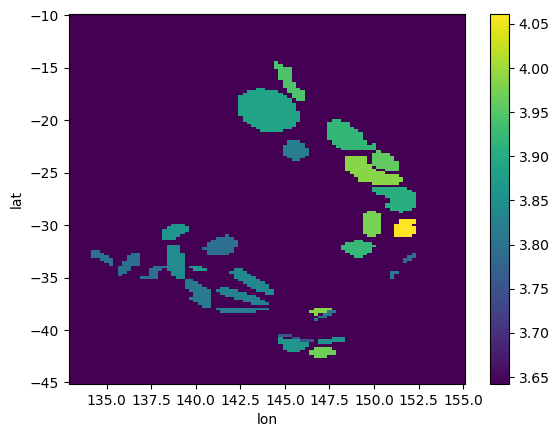

In [49]:
xr.where(wind_mask, freq_100w, 0).sum('region').plot()

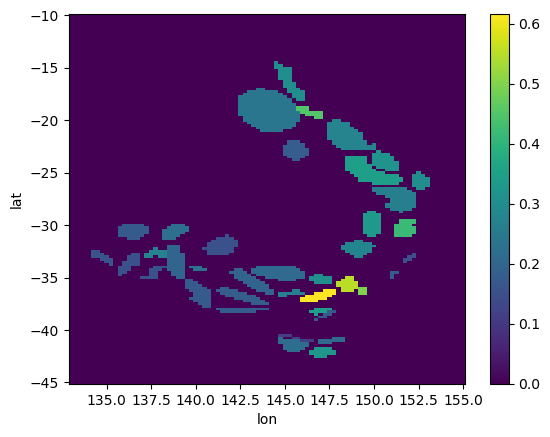

In [35]:
xr.where(rez_mask, freq_100w, 0).sum('region').plot()

In [91]:
def plot_freq(da, mask=rez_mask, vmin=0, vmax='max'):
    plot_da = xr.where(mask, da, np.nan).sum('region', skipna=True)
    plot_da = plot_da.where(mask.sum('region'))
    if vmax == 'max':
        vmax=plot_da.max().values
    
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
    ax.coastlines()
    
    plot_da.plot(ax=ax, vmin=vmin)

In [71]:
wind_mask = rez_mask.where(
    (rez_mask['region_code'] == 1) |
    (rez_mask['region_code'] == 3) |
    (rez_mask['region_code'] == 5) |
    (rez_mask['region_code'] == 7)
) # only include regions with wind

In [114]:
rez_mask.swap_dims({'region'

<xarray.DataArray 'REZ' (lat: 141, lon: 89)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat          (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.5 -44.75 -45.0
  * lon          (lon) float32 133.0 133.2 133.5 133.8 ... 154.5 154.8 155.0
    region       <U2 'N1'
    region_code  int64 3

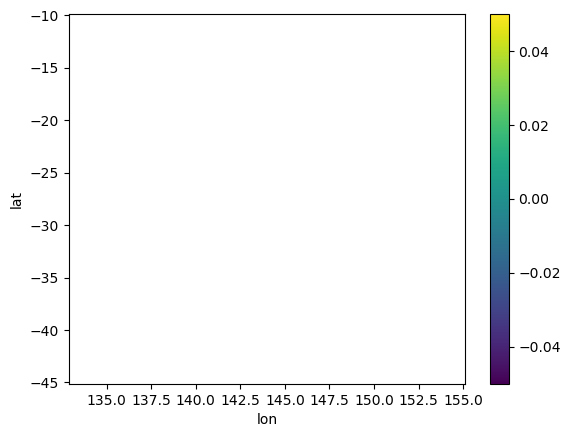

In [106]:
xr.where(wind_mask, freq_100w, np.nan).sum('region', skipna=True).plot()

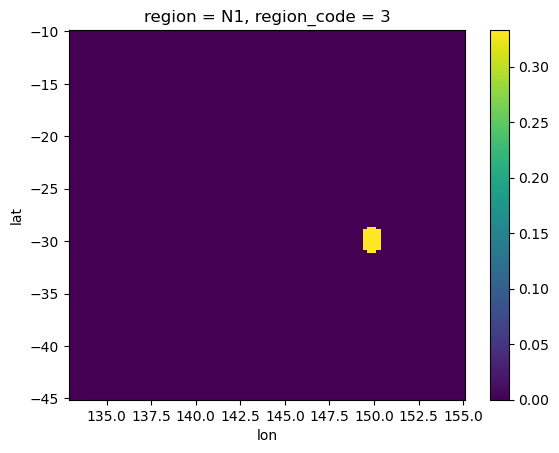

In [85]:
xr.where(wind_mask, freq_100w, 0).sel(region='N1').plot()#.sum('region', skipna=True).plot()

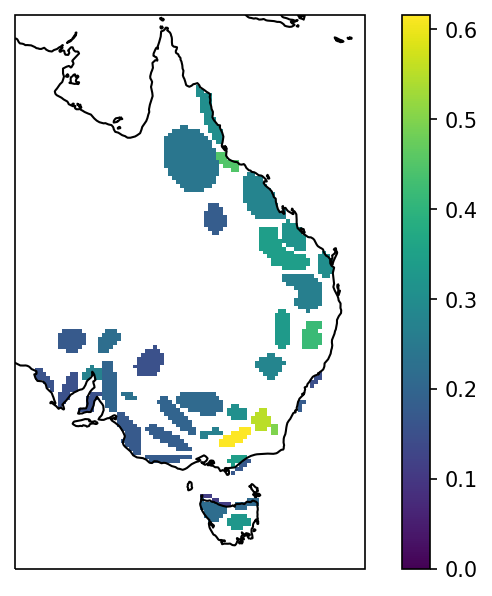

In [93]:
plot_freq(freq_100w, mask=rez_mask)

In [75]:
freq_100w.sel(region='V1')

<xarray.DataArray 'w100' ()>
array(0.6162365)
Coordinates:
    region       <U2 'V1'
    region_code  int64 6

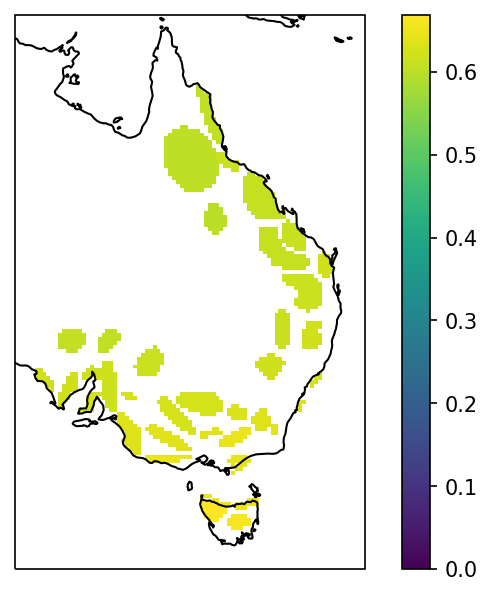

In [60]:
plot_freq(freq_mssrd)